# Trabajo cuatrimestral: Detección de Melanomas


#Introducción

La metodología utilizada actualmente para la detección de cáncer de piel consiste en un examen de screening que lo lleva a cabo un dermatólogo. Los dermatólogos utilizan distintas técnicas para evaluar las características de las lesiones cutáneas, siendo el más utilizado el Método de ABCD, entre otros. Estos métodos permiten analizar las lesiones de una persona en busca de determinar si alguna de éstas requiere de un análisis más profundo, y al ser sencillos permiten que puedan ser utilizadas por profesionales inexpertos. \\
Estos criterios se usan para decidir si la lesión se trata de una sospechosa o no sospechosa. Seguido de esto, se realiza una biopsia de los lunares para confirmar el diagnóstico presuntivo y definir la patología de la lesión.
La regla ABCD consiste en el estudio de la morfología del posible melanoma e implica el análisis de los siguientes factores:
1. Asimetría: existe un eje que divide al lunar en dos mitades distintas entre sí.
2. Borde: los bordes son irregulares e indefinidos.
3. Color: el color no es uniforme.
4. Diámetro: mayor a 6mm.


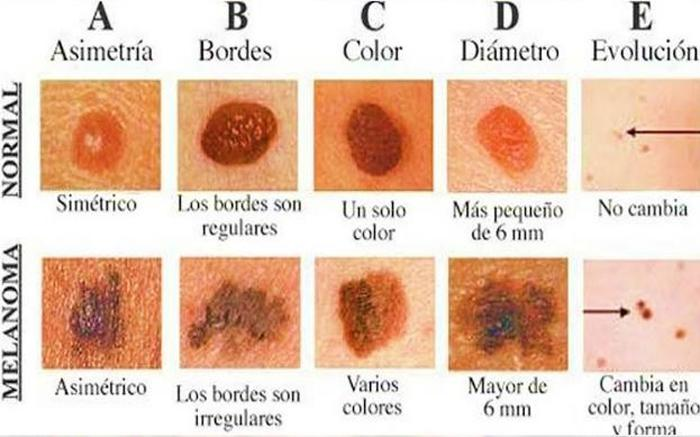

#Objetivo

El desarrollo de un software que detecte automáticamente el riesgo de una lesión en la piel a partir de los resultados histopatológicos sería de mucha utilidad ya que reduciría significativamente el tiempo de análisis de los médicos. Demás está decir que no se busca reemplazar la necesidad de realizar una biopsia para confirmar el diagnóstico de la lesión, sino el proceso evaluativo y visual de los médicos.



Considerando esta información, el presente trabajo tiene como **objetivo** el procesamiento de las imágenes y el posterior desarrollo de un algoritmo de machine learning que detecte melanomas, clasificando lesiones en benignas o malignas según ciertas características visuales como la asimetría, la circularidad, la irregularidad de los bordes, bordes internos, la cantidad de colores, algunas métricas de textura y la presencia de azul blanquecino

#Materiales y Métodos
El método propuesto consta de tres etapas: la segmentación de la lesión, la extracción de características y la clasificación del lunar mediante un modelo de Machine Learning.

##Cargado de librerías e imágenes

En primer lugar, se importan las librerías que se utilizarán a lo largo del trabajo.

In [ ]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import json
import cv2
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import signal
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Luego, se cargan las dos imágenes que utilizaremos de referencia: una benigna y otra maligna. Decidimos mostrar cómo se procesan únicamente estas dos imágenes por las limitaciones que nos presenta la RAM de Colab. Cabe mencionar que el algoritmo de *Machine Learning* empleado fue entrenado con casi 200 imágenes en un Colab anterior, con un *Database* que contenía las características calculadas por separado.

In [ ]:
imagen = cv2.imread('/content/drive/MyDrive/TP PIB/Imagenes/ref_benigna.jpg',1)
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
imagen_azul = imagen[:,:,2]

imagen_mal = cv2.imread('/content/drive/MyDrive/TP PIB/Imagenes/ref_maligna.jpg',1)
imagen_mal = cv2.cvtColor(imagen_mal, cv2.COLOR_BGR2RGB)
imagen_mal_azul = imagen_mal[:,:,2]

Text(0.5, 1.0, 'Imagen maligna original')

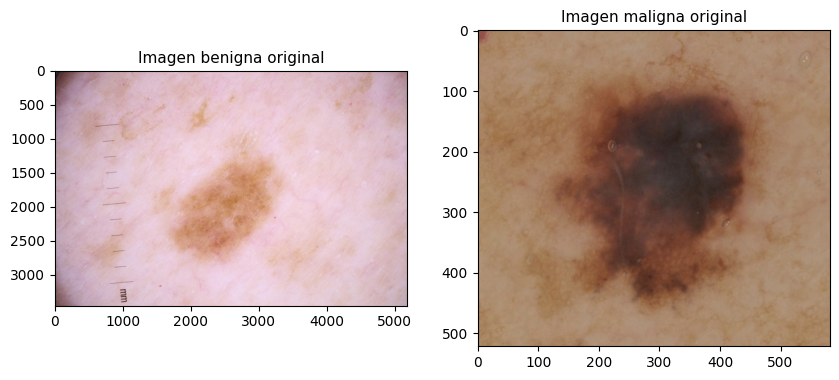

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(imagen, cmap="gray")
ax[0].set_title("Imagen benigna original",fontsize=11)
ax[1].imshow(imagen_mal, cmap='gray')
ax[1].set_title("Imagen maligna original",fontsize=11)

##Segmentacion
La segmentación se realiza para separar la lesión de la piel y establecer una región de interés que permita extraer las características de la lesión, sin que el fondo de la imagen influya en los resultados obtenidos. Consiste en una serie de pasos que dan como resultado final un ROI con la lesión a color sobre un fondo negro.  

###Binarización y morfología
Se binariza la imagen por medio del método de Otsu para separar, de manera general, la lesión del resto de la piel. Luego, se aplicaron técnicas de morfología de apertura para eliminar pequeñas agrupaciones de píxeles causadas por irregularidades en la piel.


In [ ]:
def binarizacion(imagen):
  #otsu
  umbral1, otsu = cv2.threshold(imagen,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #morfologia
  #cierre
  kernel = np.ones((3, 3), 'uint8')
  binaria_inv = (otsu==0)
  binaria_inv = binaria_inv.astype("uint8")
  binaria_dil= cv2.dilate(binaria_inv, kernel, iterations=1)
  binaria_dil_eros = cv2.erode(binaria_dil, kernel, iterations=1)
  #apertura
  binaria_dil_eros_eros= cv2.erode(binaria_dil_eros, kernel, iterations=1)
  binaria_dil_eros_eros_dil = cv2.dilate(binaria_dil_eros_eros, kernel, iterations=1)
  binaria_morf=binaria_dil_eros_eros_dil

  return binaria_morf #devuelve imagen segmentada binaria invertida

Aplicamos la binarización y las técnicas de morfología.

In [ ]:
binarizada = binarizacion(imagen_azul)
binarizada_mal = binarizacion(imagen_mal_azul)

A continuación, se observa cómo quedan las imágenes.

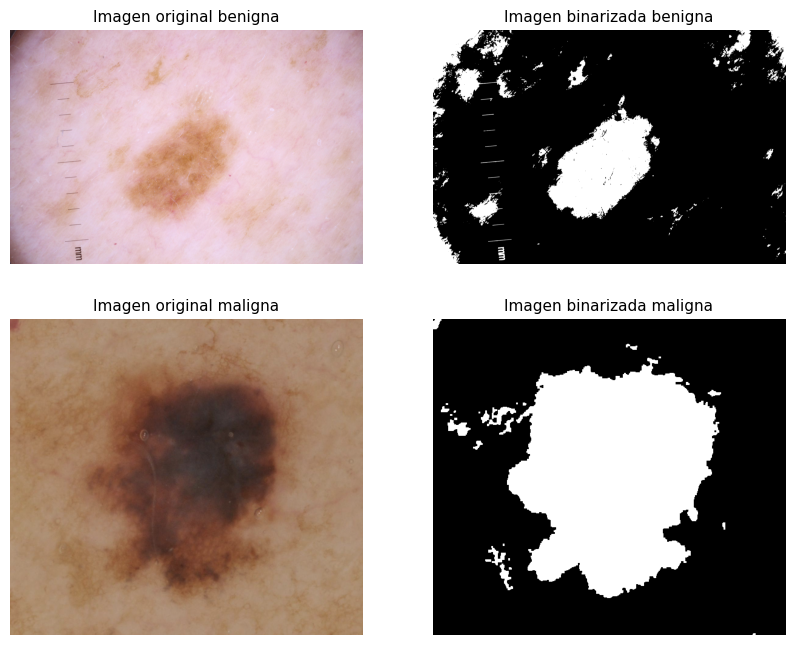

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,15))
axs[0][0].imshow(imagen, cmap="gray")
axs[0][0].set_title("Imagen original benigna",fontsize=11)
axs[0][1].imshow(binarizada, cmap='gray')
axs[0][1].set_title("Imagen binarizada benigna",fontsize=11)
axs[1][0].imshow(imagen_mal, cmap="gray")
axs[1][0].set_title("Imagen original maligna",fontsize=11)
axs[1][1].imshow(binarizada_mal, cmap='gray')
axs[1][1].set_title("Imagen binarizada maligna",fontsize=11)
axs = axs.flatten()
for ax in axs:
  ax.axis('off')
plt.subplots_adjust(hspace=-0.6, wspace=0.2)
plt.show()

### Bounding box

Se realiza el Bounding Box para delimitar la región del lunar o lesión. Se selecciona el 'box' de mayor tamaño y más centrado en la imagen original.

In [ ]:
def bounding_box(imagen, binaria):
  #bounding box
  cnts = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  imagen2 = imagen.copy()
  original = imagen2.copy()

  h_max = 0
  w_max = 0
  y_max = 0
  x_max = 0

  alto_im, ancho_im = imagen.shape
  dif_centro = 10**10
  #me quedo con el bounding box mas grande y que este mas centrado
  for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if dif_centro > math.sqrt((alto_im/2-(y+h/2))**2 + (ancho_im/2-(x+w/2))**2):
      if h*w > h_max*w_max and h >= 20 and w >= 20:
        h_max = h
        w_max = w
        x_max = x
        y_max = y
        dif_centro = math.sqrt((alto_im/2-(y+w/2))**2 + (ancho_im/2-(x+h/2))**2)
    #cv2.rectangle(imagen2, (x, y), (x + w, y + h), (36,255,12), 2) # parámetros, img, punto inicial, punto final, color, espesor
  ROI = original[y_max:y_max+h_max, x_max:x_max+w_max]

  #binarizo con otsu cada ROI
  umbral, otsu = cv2.threshold(ROI,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  binaria_inv = (otsu==0)
  binaria_inv = binaria_inv.astype("uint8")

  return ROI, binaria_inv, h_max, w_max, y_max, x_max

In [ ]:
ROI_azul, ROI_bin, h_max, w_max, y_max, x_max = bounding_box(imagen_azul, binarizada)
ROI_color = imagen[y_max:y_max+h_max, x_max:x_max+w_max]

In [ ]:
ROI_mal_azul, ROI_mal_bin, h_mal_max, w_mal_max, y_mal_max, x_mal_max = bounding_box(imagen_mal_azul, binarizada_mal)
ROI_mal_color = imagen_mal[y_mal_max:y_mal_max+h_mal_max, x_mal_max:x_mal_max+w_mal_max]

Se calculan los ROIS en la imagen original y también binarizada.

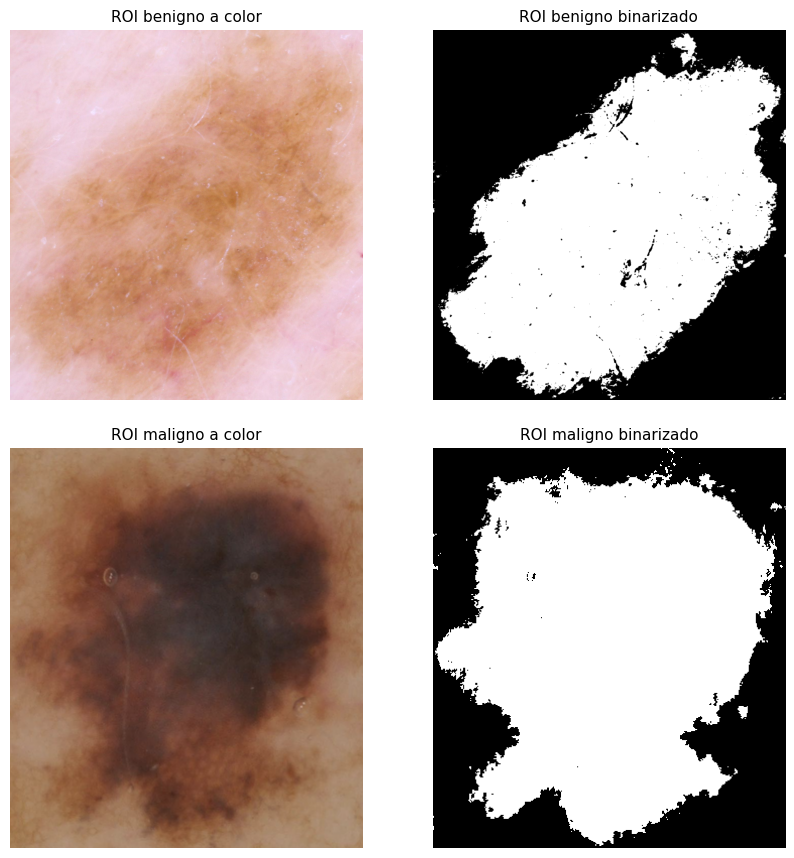

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,15))
axs[0][0].imshow(ROI_color, cmap="gray")
axs[0][0].set_title("ROI benigno a color",fontsize=11)
axs[0][1].imshow(ROI_bin, cmap="gray")
axs[0][1].set_title("ROI benigno binarizado",fontsize=11)
axs[1][0].imshow(ROI_mal_color, cmap='gray')
axs[1][0].set_title("ROI maligno a color",fontsize=11)
axs[1][1].imshow(ROI_mal_bin, cmap='gray')
axs[1][1].set_title("ROI maligno binarizado",fontsize=11)
axs = axs.flatten()
for ax in axs:
  ax.axis('off')
plt.subplots_adjust(hspace=-0.4, wspace=0.2)
plt.show()

### Original con fondo negro
Se multiplican el ROI a color y el ROI binarizado para obtener una imagen con fondo negro y el lunar o lesión a color.

In [ ]:
# Separar las capas RGB de la imagen original
r, g, b = cv2.split(ROI_color)

# Multiplicar cada capa por la imagen binarizada
r_multiplicada = r * ROI_bin
g_multiplicada = g * ROI_bin
b_multiplicada = b * ROI_bin

# Combinar las capas multiplicadas
imagen_color_fondonegro = cv2.merge((r_multiplicada, g_multiplicada, b_multiplicada))

In [ ]:
# Separar las capas RGB de la imagen original
rmal, gmal, bmal = cv2.split(ROI_mal_color)

# Multiplicar cada capa por la imagen binarizada
r_multiplicada_mal = rmal * ROI_mal_bin
g_multiplicada_mal = gmal * ROI_mal_bin
b_multiplicada_mal = bmal * ROI_mal_bin

# Combinar las capas multiplicadas
imagen_color_fondonegro_mal = cv2.merge((r_multiplicada_mal, g_multiplicada_mal, b_multiplicada_mal))

El resultado final de la segmentacion es:

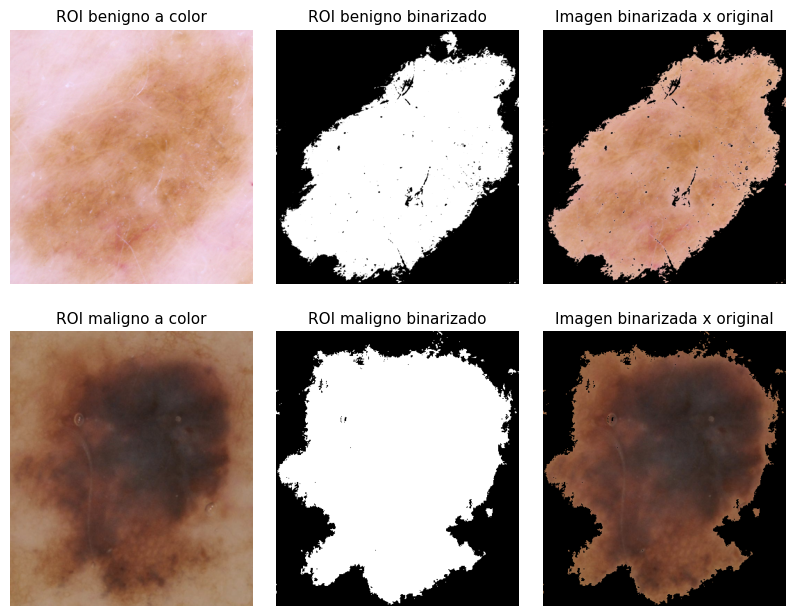

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(10,15))
axs[0][0].imshow(ROI_color, cmap="gray")
axs[0][0].set_title("ROI benigno a color",fontsize=11)
axs[0][1].imshow(ROI_bin, cmap="gray")
axs[0][1].set_title("ROI benigno binarizado",fontsize=11)
axs[0][2].imshow(imagen_color_fondonegro, cmap="gray")
axs[0][2].set_title("Imagen binarizada x original",fontsize=11)


axs[1][0].imshow(ROI_mal_color, cmap='gray')
axs[1][0].set_title("ROI maligno a color",fontsize=11)
axs[1][1].imshow(ROI_mal_bin, cmap='gray')
axs[1][1].set_title("ROI maligno binarizado",fontsize=11)
axs[1][2].imshow(imagen_color_fondonegro_mal, cmap="gray")
axs[1][2].set_title("Imagen binarizada x original",fontsize=11)
axs = axs.flatten()
for ax in axs:
  ax.axis('off')
plt.subplots_adjust(hspace=-0.63, wspace=0.1)
plt.show()

Entonces, nos quedamos con estos dos ROIS:

Text(0.5, 1.0, 'ROI maligno a color, fondo negro')

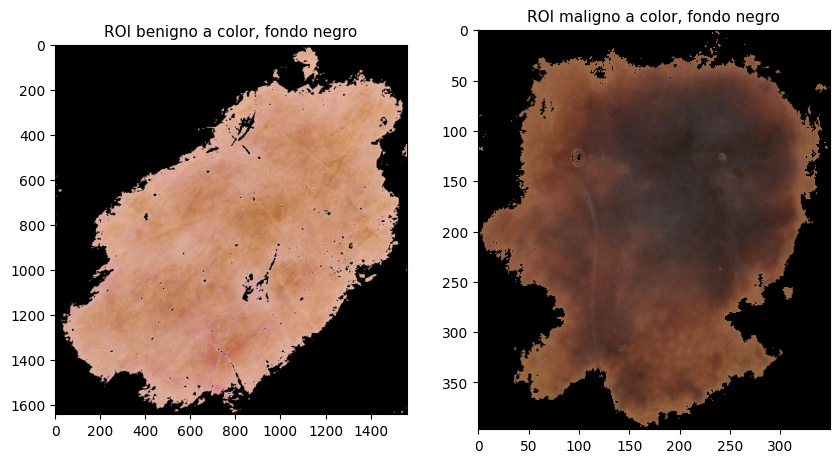

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(imagen_color_fondonegro, cmap="gray")
ax[0].set_title("ROI benigno a color, fondo negro",fontsize=11)
ax[1].imshow(imagen_color_fondonegro_mal, cmap='gray')
ax[1].set_title("ROI maligno a color, fondo negro",fontsize=11)

Notamos que efectivamente tenemos un ROI (la cantidad de píxeles en ambas imágenes es menor que en la original), donde la lesión se ve a color sobre un fondo negro.

##Extracción de características
La extracción de características es un paso fundamental ya que es lo que se usará para entrenar al modelo de Machine. A continuación, se detalla brevemente los pasos que se realizaron para obtener las distintas características mencionadas anteriormente.

###Asimetria

Para el análisis de asimetría se basa en la
partición de la imagen en una cantidad N de cuadros dependiente del tamaño de la imagen y el análisis de las particiones a partir de algunos criterios definidos. En el algoritmo diseñado, el criterio analizado fue el valor medio de intensidad de la imagen total.
El primer paso de este algoritmo consiste en el cálculo de la intensidad media de cada partición de la imagen. Las particiones fueron etiquetadas si el valor de intensidad fue mayor la media de todo el ROI.
Luego se dividió la imagen en cuatro cuadrantes y se analizó la cantidad de particiones etiquetados en cada cuadrante.

In [ ]:
def asimetria (imagen,imagen_bin, ROI):
  #calculo la media de intensidad de todo el lunar
  media_intensidad = cv2.mean(ROI)[0]

  #recorto la imagen en cuadrados

  # Obtiene las dimensiones de la ROI
  alto, ancho = ROI.shape

  # Tamaño de los cuadrados
  tamano_cuadrado_alto = alto//20
  tamano_cuadrado_ancho = ancho//20

  # Inicializa una lista para almacenar los cuadrados
  cuadrados = []
  medias = []
  imagen_resultante=np.zeros(ROI.shape)
  imagen_resultante2=np.zeros(ROI.shape)
  # Recorre la imagen en pasos de 12x12
  for i in range(0, alto, tamano_cuadrado_alto):
      for j in range(0, ancho, tamano_cuadrado_ancho):
          cuadrado = ROI[i:i + tamano_cuadrado_alto, j:j + tamano_cuadrado_ancho]
          media = int(np.mean(cuadrado))
          for k in range (cuadrado.shape[0]):
            for l in range (cuadrado.shape[1]):
              imagen_resultante[i+k, j+l]=media
              if media>=media_intensidad:
                imagen_resultante2[i+k, j+l]=255

          cuadrados.append(cuadrado)
          medias.append(media)


  #dividimos en 4 cuadrantes y calculamos la cantidad de cuadrados con 0 en cada cuadrante
  mitad_ancho=ancho//2
  mitad_alto=alto//2

  #primer cuadrante
  cuadrante1=0
  for i in range(0, mitad_alto, tamano_cuadrado_alto):
      for j in range(0, mitad_ancho, tamano_cuadrado_ancho):
        if imagen_resultante2[i+tamano_cuadrado_alto//2][j+tamano_cuadrado_ancho//2] == 0:
          cuadrante1+=1


  #segundo cuadrante
  cuadrante2=0
  for i in range(0, mitad_alto, tamano_cuadrado_alto):
      for j in range(mitad_ancho, ancho-(tamano_cuadrado_ancho), tamano_cuadrado_ancho):
        if imagen_resultante2[i+tamano_cuadrado_alto//2][j+tamano_cuadrado_ancho//2] == 0:
          cuadrante2+=1


  #tercer cuadrante
  cuadrante3=0
  for i in range(mitad_alto, alto-tamano_cuadrado_alto, tamano_cuadrado_alto):
      for j in range(0, mitad_ancho, tamano_cuadrado_ancho):
        if imagen_resultante2[i+tamano_cuadrado_alto//2][j+tamano_cuadrado_ancho//2]== 0:
          cuadrante3+=1


  #cuarto cuadrante
  cuadrante4=0
  for i in range(mitad_alto, alto-tamano_cuadrado_alto, tamano_cuadrado_alto):
      for j in range(mitad_ancho, ancho-(tamano_cuadrado_ancho), tamano_cuadrado_ancho):
        if imagen_resultante2[i+tamano_cuadrado_alto//2][j+tamano_cuadrado_ancho//2]== 0:
          cuadrante4+=1


  media_cuadrante=np.mean([cuadrante1, cuadrante2, cuadrante3, cuadrante4])


  #coeficiente de asimetria
  coef_asimetria2=math.sqrt((cuadrante1+cuadrante2-(cuadrante3+cuadrante4))**2+(cuadrante1+cuadrante3-(cuadrante2+cuadrante4))**2)

  return coef_asimetria2, imagen_resultante, imagen_resultante2





In [ ]:
asimetria2_ben, resultante_ben, resultante2_ben = asimetria(imagen,binarizada, ROI_azul)
asimetria2_mal, resultante_mal, resultante2_mal = asimetria(imagen_mal,binarizada_mal, ROI_mal_azul)

En una primera instancia se divide al ROI en cuadrados de 12 x 12 y se completa a cada cuadrado con la media de intensidad del mismo dando como resultado el cuadriculado a continuación.

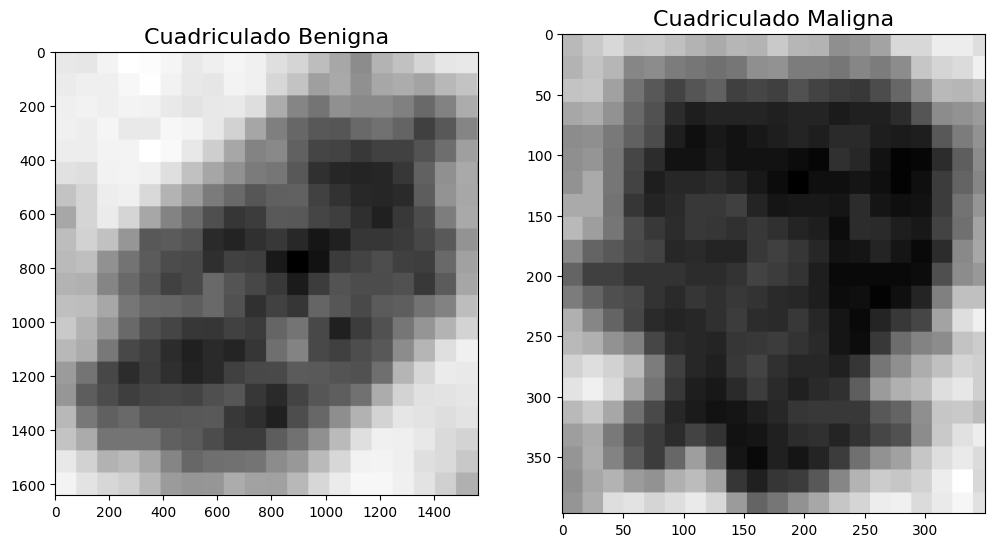

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(resultante_ben,cmap='gray'),plt.title('Cuadriculado Benigna',fontsize=16)
plt.subplot(122),plt.imshow(resultante_mal,cmap='gray'), plt.title('Cuadriculado Maligna',fontsize=16)
plt.show()

Luego se marcan los cuadrados negros en los casos en que el valor de intensidad del cuadrado esta por arriba de la media del ROI. Se divide a la imagen en 4 cuadrantes y se cuenta la cantidad de cuadrados negros en cada cuadrante con el fin de determinar asimetría horizontal y/o vertical.

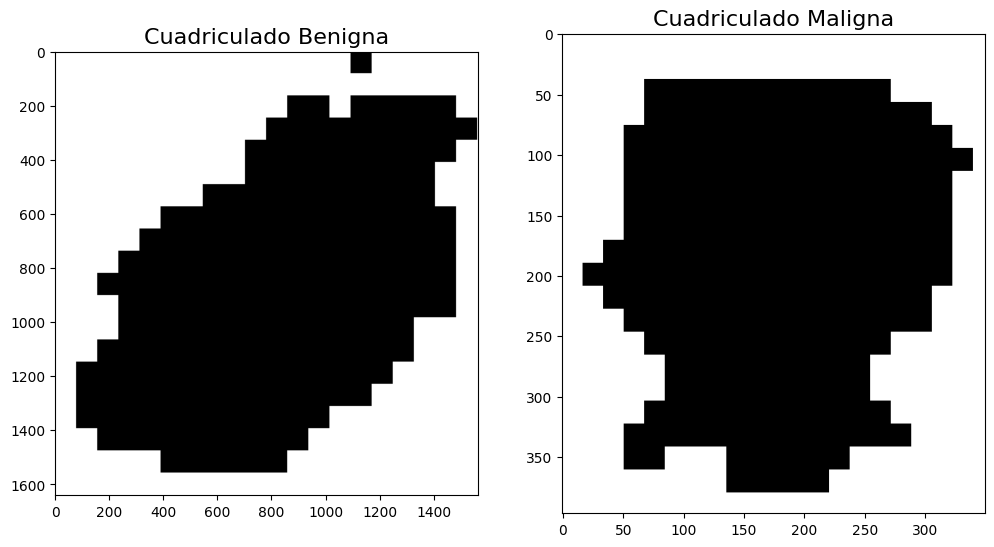

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(resultante2_ben,cmap='gray'),plt.title('Cuadriculado Benigna',fontsize=16)
plt.subplot(122),plt.imshow(resultante2_mal,cmap='gray'), plt.title('Cuadriculado Maligna',fontsize=16)
plt.show()

###Irregularidad de los bordes y Desviación del Círculo

En base a técnicas de detección de bordes se busca determinar la irregularidad de los bordes y la desviación del circulo o la circularidad de la lesión.

In [ ]:
def circularidad (ROI):

  #binarizo con otsu cada ROI
  umbral, otsu = cv2.threshold(ROI,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  binaria_inv = (otsu==0)
  binaria_inv = binaria_inv.astype("uint8")

  #calculo la cantidad de pixeles blancos que hay en la binarizada = Area
  area=len(np.where(binaria_inv==1)[0])

  #calculo el borde de canny sobre la imagen binarizada
  canny = cv2.Canny(binaria_inv, 1, 1)

  #cuento la cantidad de pixeles blancos que hay en los bordes canny = perimetro
  perimetro = len(np.where(canny==255)[0])

  #calculo el centro de masa
  x_array=np.where(binaria_inv==1)[1]
  xcm=sum(x_array)/len(x_array)
  y_array=np.where(binaria_inv==1)[0]
  ycm=sum(y_array)/len(y_array)

  #calculo la distancia de los bordes al cm
  min_dist=10**10
  max_dist=0
  x_border=np.where(canny==255)[1]
  y_border=np.where(canny==255)[0]
  dist_euc=[]
  for i in range(len(x_border)):
    dist_euc.append(math.sqrt((xcm-x_border[i])**2+(ycm-y_border[i])**2))

  #maximas y minimas distancias
  max_dist=np.max(dist_euc)
  min_dist=np.min(dist_euc)

  #desviacion estandar de las distancias al cm
  dist_prom=np.mean(dist_euc)
  suma=0
  for i in range(len(dist_euc)):
    suma+=(dist_euc[i]-dist_prom)**2
  std=math.sqrt((1/(len(dist_euc)-1))*suma)


  circular=(4*math.pi*area)/(perimetro**2)
  coef_irregularidad1=perimetro/area
  coef_irregularidad2=perimetro/max_dist
  coef_irregularidad3=perimetro*((1/min_dist)-(1/max_dist))

  ROI_area=binaria_inv*ROI
  ROI_ec = cv2.equalizeHist(ROI_area)
  canny2 = cv2.Canny(ROI_ec, 100, 120)
  prop_bordes_canny = (len(np.where(canny2==255)[0])-perimetro)/(area)



  return coef_irregularidad2, std, prop_bordes_canny, binaria_inv, canny, canny2


In [ ]:
irr_borde_ben, desv_circulo_ben, borde_canny_ben, otsu_ben, canny_ben, canny2_ben = circularidad(ROI_azul)
irr_borde_mal, desv_circulo_mal, borde_canny_mal, otsu_mal, canny_mal, canny2_mal = circularidad(ROI_mal_azul)

Lo que primero se realiza es binarizar la región de interés con Otsu y determinar el área de la lesión según la cantidad de píxeles segmentados.

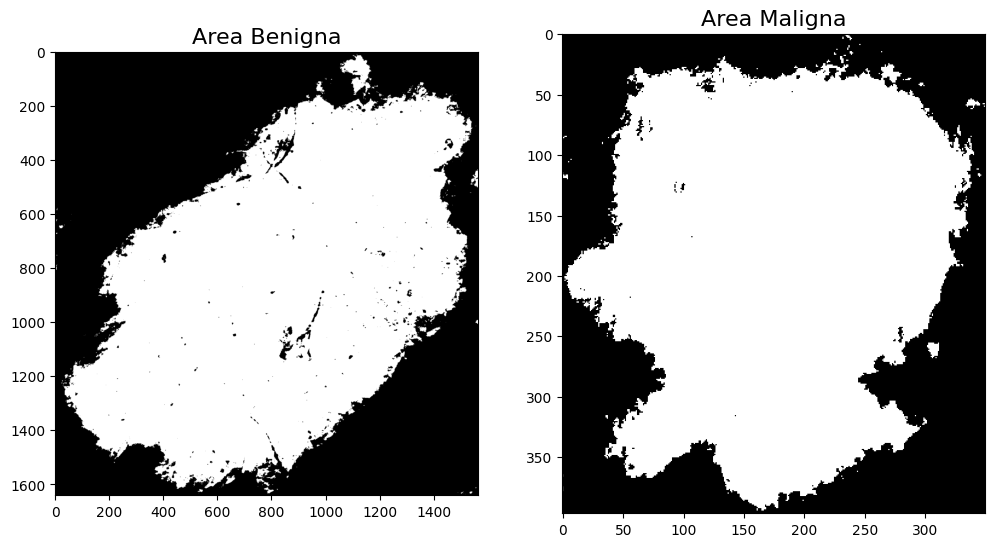

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(otsu_ben,cmap='gray'),plt.title('Area Benigna',fontsize=16)
plt.subplot(122),plt.imshow(otsu_mal,cmap='gray'), plt.title('Area Maligna',fontsize=16)
plt.show()

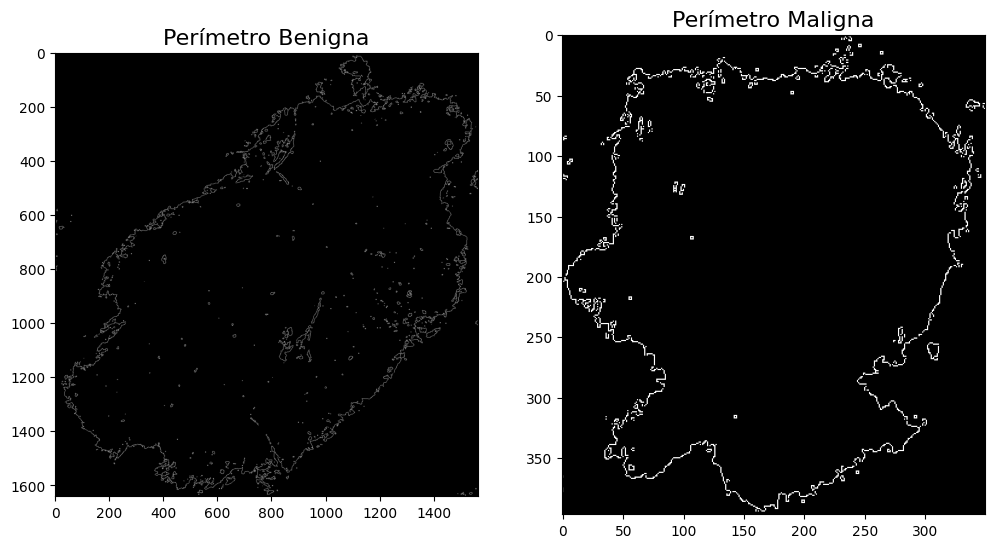

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(canny_ben,cmap='gray'),plt.title('Perímetro Benigna',fontsize=16)
plt.subplot(122),plt.imshow(canny_mal,cmap='gray'), plt.title('Perímetro Maligna',fontsize=16)
plt.show()

Posteriormente, se calcula el borde de estas imágenes binarizadas para aproximar el perímetro de la lesión como la cantidad de píxeles blancos resultantes del Algoritmo de Canny.


Con el fin de medir la irregularidad de los bordes, se calcula el centro de masa o punto medio del área segmentada y se mide la distancia euclídea de cada uno de los píxeles del perímetro al centro. De esta forma, es posible determinar que tanta ‘dispersión’ presentan los bordes con respecto a una distancia del centro de masa.

El coeficiente utilizado fue:


 coeficiente de irregularidad de bordes = perímetro/ máxima distancia euclídea


Para medir la desviación del círculo, es decir que tan distinta es la lesión a un círculo homogéneo, se calcula la desviación estándar de todas las distancias euclideas según:


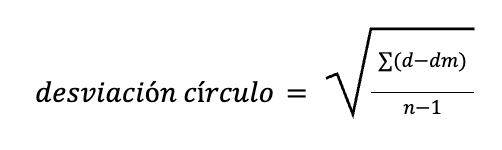

donde n es la longitud del array de distancia euclídea, d es la distancia euclídea para cada pixel y dm la distancia promedio del centro de masa al perímetro.

###Bordes Internos

Dado que las lesiones malignas suelen tener mayores irregularidades dentro de la lesión, se buscan los bordes internos dentro del área previamente encontrada. Se realiza una ecualización del histograma para aumentar el contraste en los niveles de gris presentes solo en el área de la lesión y se utiliza nuevamente el Algoritmo de Canny para identificar los bordes internos. Luego, se resta el perímetro y se normaliza con el área de la lesión. Las imágenes resultantes al buscar los bordes internos se muestran a continuación.


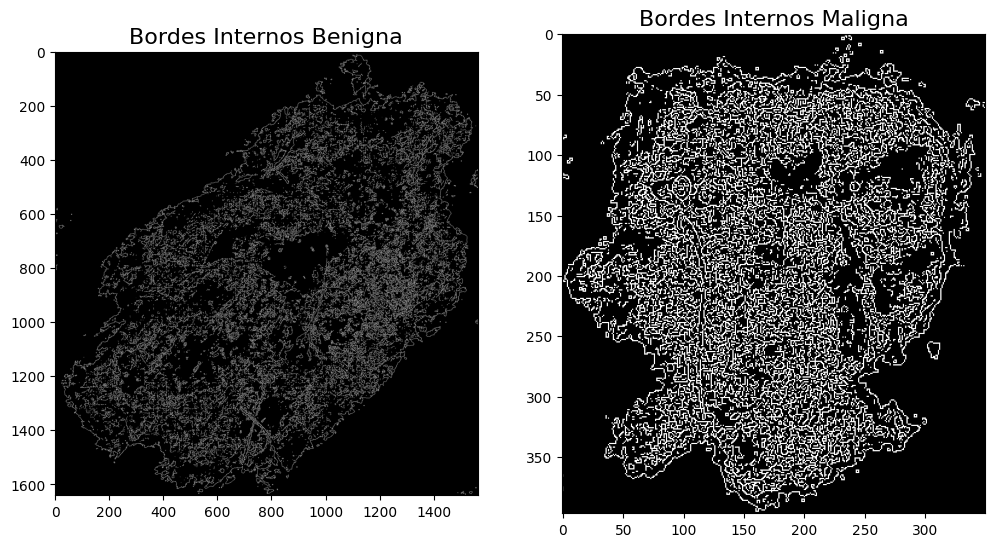

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(canny2_ben,cmap='gray'),plt.title('Bordes Internos Benigna',fontsize=16)
plt.subplot(122),plt.imshow(canny2_mal,cmap='gray'), plt.title('Bordes Internos Maligna',fontsize=16)
plt.show()

###Cantidad de colores
Se extraen los colores dominantes de la imagen. Esto se realiza teniendo en cuenta los colores típicos que pueden aparecer (rojos, marrones), estableciendo rangos en RGB que permita diferenciar la presencia de estos colores en los píxeles de la imagen. La elección de los rangos se definió a partir de algunas muestras que se utilizaron en trabajos similares al nuestro. Además, se busca que haya por lo menos un 2% de los píxeles en ese rango para considerarlos como un color.

In [ ]:
def cantidad_tot(imagen):
  colores = []

  rangos = [ #BGR
    (np.array([200, 200, 200], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)),
    (np.array([185, 180, 180], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)),
    (np.array([180, 115, 180], dtype=np.uint8), np.array([255, 180, 255], dtype=np.uint8)),
    (np.array([0, 0, 0], dtype=np.uint8), np.array([100, 115, 125], dtype=np.uint8)),
    (np.array([0, 50, 153], dtype=np.uint8), np.array([100, 153, 198], dtype=np.uint8)),
    (np.array([0, 0, 50], dtype=np.uint8), np.array([100, 170, 153], dtype=np.uint8)),
    (np.array([100, 100, 0], dtype=np.uint8), np.array([180, 125, 153], dtype=np.uint8))
  ]

  for rango in rangos:
    mask = cv2.inRange(imagen, rango[0], rango[1])

    # Contar píxeles en cada máscara y porcentaje
    count = np.count_nonzero(mask)

    porcentaje = (count / (imagen.shape[0] * imagen.shape[1])) * 100

    if porcentaje >= 1.5:
      colores.append(porcentaje)

  return colores

En el caso de los benignos, tenemos:

In [ ]:
colores_ben = cantidad_tot(imagen_color_fondonegro)
cantidad_ben = len(colores_ben)
print('La cantidad de colores es:', cantidad_ben)

La cantidad de colores es: 1


Por otro lado, la lesión maligna presenta:

In [ ]:
colores_mal = cantidad_tot(imagen_color_fondonegro_mal)
cantidad_mal = len(colores_mal)
print('La cantidad de colores es:', cantidad_mal)

La cantidad de colores es: 3


###Azul blanquecino
El azul blanquecino se obtiene de manera similar a la cantidad de colores. Se busca que haya píxeles en un rango RGB de este color y sus variaciones. Se establece un umbral de 0.5% con el objetivo de que la más mínima presencia de este color, sin tener en cuenta posibles píxeles aislados de este color, sea detectado.

In [ ]:
def azulgris(imagen):
  #Los rangos estan en BGR
  rango_color_bajo1 = np.array([148, 123, 148], dtype=np.uint8)
  rango_color_alto1 = np.array([152, 127, 152], dtype=np.uint8)

  rango_color_bajo2 = np.array([148, 123, 123], dtype=np.uint8)
  rango_color_alto2 = np.array([152, 127, 127], dtype=np.uint8)

  rango_color_bajo3 = np.array([123, 98, 98], dtype=np.uint8)
  rango_color_alto3 = np.array([127, 102, 102], dtype=np.uint8)

  rango_color_bajo4 = np.array([148, 123, 98], dtype=np.uint8)
  rango_color_alto4 = np.array([152, 127, 102], dtype=np.uint8)

  rango_color_bajo5 = np.array([148, 98, 48], dtype=np.uint8)
  rango_color_alto5 = np.array([151, 102, 102], dtype=np.uint8)

  rango_color_bajo6 = np.array([148, 98, 0], dtype=np.uint8)
  rango_color_alto6 = np.array([152, 102, 2], dtype=np.uint8)

  # Crear una máscara para el rango de colores
  mask1 = cv2.inRange(imagen, rango_color_bajo1, rango_color_alto1)
  mask2 = cv2.inRange(imagen, rango_color_bajo2, rango_color_alto2)
  mask3 = cv2.inRange(imagen, rango_color_bajo3, rango_color_alto3)
  mask4 = cv2.inRange(imagen, rango_color_bajo4, rango_color_alto4)
  mask5 = cv2.inRange(imagen, rango_color_bajo5, rango_color_alto5)
  mask6 = cv2.inRange(imagen, rango_color_bajo6, rango_color_alto6)

  # Cuenta la cantidad de píxeles que cumplen con el rango
  pixeles_cumplen_rango = np.count_nonzero(mask1) + np.count_nonzero(mask2) + np.count_nonzero(mask3) + np.count_nonzero(mask4) + np.count_nonzero(mask5) + np.count_nonzero(mask6)

  # Calcula el porcentaje de píxeles que cumplen con el rango con respecto al total de píxeles no negros
  porcentaje = (pixeles_cumplen_rango / (imagen.shape[0] * imagen.shape[1])) * 100

  if porcentaje >= 0.5:
    return 1
  else:
    return 0

La imagen benigna:

In [ ]:
tiene_color_azul_ben = azulgris(imagen_color_fondonegro)
if tiene_color_azul_ben == 1:
  print('Presenta azul blanquecino')
else:
  print('No presenta azul blanquecino')

No presenta azul blanquecino


La imagen maligna:

In [ ]:
tiene_color_azul_mal = azulgris(imagen_color_fondonegro_mal)
if tiene_color_azul_mal == 1:
  print('Presenta azul blanquecino')
else:
  print('No presenta azul blanquecino')

Presenta azul blanquecino


###Intensidad de la capa azul
La cantidad de la capa azul se calcula como el promedio de las intensidades de todos los píxeles de la imagen del ROI azul.

In [ ]:
promedio_ben = np.mean(ROI_azul)
print("media intensidad azul benigna:", np.mean(promedio_ben))

media intensidad azul benigna: 160.12858676204723


In [ ]:
promedio_mal = np.mean(ROI_mal_azul)
print("media intensidad azul benigna:", np.mean(promedio_mal))

media intensidad azul benigna: 66.58327455919395


###Texturas

De acuerdo con Kavitha, la textura de la piel juega un papel crucial en el diagnóstico y análisis del melanoma. Las características texturales de una lesión en la piel, como la rugosidad, la regularidad, y la variabilidad en color y tono, pueden ser indicativos de la presencia de melanoma. Por ejemplo, una superficie irregular, heterogénea o con patrones asimétricos en una lesión cutánea puede sugerir malignidad.

Como punto de partida para el análisis de texturas, hicimos el cálculo de la matriz de correlación para la evaluación de textura. Esta matriz nos permite cuantificar la relación entre los píxeles de una imagen, lo que sirve para clasificar las lesiones cutáneas. La misma muestra como la intensidad de un píxel está relacionada con la intensidad de otros píxeles vecinos.
Luego, nos basamos en esta matriz para calcular las métricas; energía, entropía y correlación.


In [ ]:
def matriz_de_co_ocurrencia (imagen):
  co_occurrence_matrix = cv2.calcHist([imagen], [0], None, [256], [0, 256])
  co_occurrence_matrix /= co_occurrence_matrix.sum()
  return co_occurrence_matrix

La energía refleja la uniformidad y la repetición de patrones de intensidad. Por lo tanto, las lesiones malignas suelen tener patrones de crecimiento más agresivos y desorganizados, lo que podría traducirse en una menor energía en la matriz de coocurrencia.

Para calcular la energía, se usó la siguiente fórmula:





$$ f_1 = \sum_{i,j} g(i,j)^2 $$

In [ ]:
def energia(mat):
  return np.sum(mat**2)

La entropía mide la aleatoriedad y la complejidad de la distribución de intensidad en la imagen. Esta métrica cuantifica cuán aleatoria es la distribución de los niveles de intensidad de los píxeles, lo que habla sobre la irregularidad y el desorden presentes en la textura de la piel. En el diagnóstico del melanoma, la entropía puede ser una medida de heterogeneidad o uniformidad.

Para calcular la entropía, se usó la siguiente fórmula:

$$
f_2 = \begin{cases}
\sum_{i,j} g(i,j) \log_2 g(i,j) & \text{if } g(i,j) \neq 0 \\
0 & \text{if } g(i,j) = 0
\end{cases}
$$


In [ ]:
def entropia(mat):
  g_non_zero = mat[mat > 0]
  return -np.sum(g_non_zero * np.log2(g_non_zero))

La correlación ayuda a medir la homogeneidad o la variabilidad espacial de las texturas en las imágenes dermatológicas. Nos da información sobre las propiedades estructurales de las lesiones cutáneas.

Para calcular la correlación, se usó la siguiente fórmula:

$$
f_3 = \sum_{i,j} \frac{(i - \mu)(j - \mu)g(i,j)}{\sigma^2}
$$


In [ ]:
def correlacion(mat):
  rows, cols = mat.shape
  mu = sum(i * mat[i, j] for i in range(rows) for j in range(cols))
  sigma = sum((i - mu) ** 2 * mat[i, j] for i in range(rows) for j in range(cols))
  return sum((i - mu) * (j - mu) * mat[i, j] for i in range(rows) for j in range(cols)) / sigma

In [ ]:
mat_roi_azul = matriz_de_co_ocurrencia(ROI_azul)
mat_roi_mal_azul = matriz_de_co_ocurrencia(ROI_mal_azul)

In [ ]:
energia_roi_azul = energia(mat_roi_azul)
entropia_roi_azul = entropia(mat_roi_azul)
correlacion_roi_azul = correlacion(mat_roi_azul)

In [ ]:
energia_roi_mal_azul = energia(mat_roi_mal_azul)
entropia_roi_mal_azul = entropia(mat_roi_mal_azul)
correlacion_roi_mal_azul = correlacion(mat_roi_mal_azul)

In [ ]:
print(f"Energia ROI Benigno azul: {energia_roi_azul}")
print(f"Entropia ROI Benigno azul: {entropia_roi_azul}")
print(f"Correlacion Benigno ROI azul: {correlacion_roi_azul}")

print(f"Energia ROI Maligno azul: {energia_roi_mal_azul}")
print(f"Entropia ROI Maligno azul: {entropia_roi_mal_azul}")
print(f"Correlacion Maligno ROI azul: {correlacion_roi_mal_azul}")

Energia ROI Benigno azul: 0.0075876107439398766
Entropia ROI Benigno azul: 7.160958766937256
Correlacion Benigno ROI azul: 1.214015590008565e-08
Energia ROI Maligno azul: 0.015174269676208496
Entropia ROI Maligno azul: 6.265669345855713
Correlacion Maligno ROI azul: -3.512439682217837e-08


##Modelo Machine Learning
El objetivo final del trabajo es lograr predecir con algún algoritmo de Inteligencia Artificial la probabilidad de que un lunar sea maligno. No se busca que clasifique por sí (1) o por no (0) las distintas imágenes de las lesiones, sino que el modelo empleado asigne una probabilidad de que ese lunar en particular sea maligno. Por lo tanto, mientras esa probabilidad sea baja es debido a que el modelo considera que el lunar es benigno, y de lo contrario, maligno.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

###Data Exploration

Se cargo el database generado con el mismo procesamiento detallado anteriormente pero para 175 imagenes, por lo que el database posee 175 filas y 11 columnas (una para cada una de las 10 metricas y la columna *target* que clasifica la lesion en maligna [1] o benigna [0])

In [ ]:
db = pd.read_csv('/content/drive/MyDrive/TP PIB/nuestro_database2.csv')

In [ ]:
db['sex'].replace(['female','male'],[0,1], inplace=True)

In [ ]:
db.rename(columns={'Asimetria 2': 'Asimetria'}, inplace=True)
db.rename(columns={'Coef Irregularidad 2': 'Coef Irregularidad'}, inplace=True)


X = db.copy()
y = X.target

#Eliminamos la columna que define el diagnóstico del caso y las caracterisitcas que no sera utilizadas
X = db.drop(['age_approx','anatom_site_general_challenge',	'diagnosis', 'benign_malignant', 'image_name', 'patient_id', 'sex', 'Asimetria 1','Coef Irregularidad 1','Coef Irregularidad 3','Circularidad', 'Momento Diferencia Inversa', 'Energia', 'Entropia', 'Correlacion'],axis=1)

X.rename(columns={'energia2': 'Energia'}, inplace=True)
X.rename(columns={'entropia2': 'Entropia'}, inplace=True)
X.rename(columns={'correlacion2': 'Correlacion'}, inplace=True)

print('Tamaño: ', X.shape)

Tamaño:  (175, 11)


A continuacion se ve el database:

In [ ]:
X.head()

target  Asimetria  Coef Irregularidad  Desviacion Circulo    Bordes  \
0       0  45.099889           27.892975           81.950432  0.168281   
1       0   8.246211           19.656545           82.522639  0.059170   
2       0  13.341664           29.314242          109.107890  0.103744   
3       0  28.635642           30.497766          139.556725  0.093798   
4       0  18.601075           26.407120           99.990832  0.082489   

   Cantidad colores  Azul maligno  Intensidad capa azul   Energia  Entropia  \
0               1.0           0.0            169.087655  0.012261  6.662765   
1               1.0           0.0             92.337328  0.006480  7.387588   
2               1.0           0.0            135.243623  0.007050  7.283440   
3               1.0           0.0            145.690827  0.008743  7.195383   
4               1.0           0.0            141.733031  0.009311  7.020835   

    Correlacion  
0 -8.816412e-08  
1  4.427177e-09  
2  1.156877e-08  
3  4.188061e-08  
4  5.525595e-08

Recuento de imagenes clasificadas como benignas y malignas en el database a utilizar

<Axes: xlabel='benign_malignant', ylabel='count'>

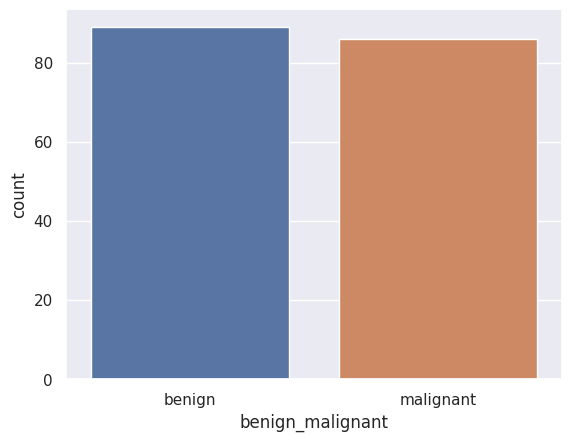

In [ ]:
sns.countplot(x=db['benign_malignant'])

Se procedio a calcular las correlacion de cada variable con el *target*

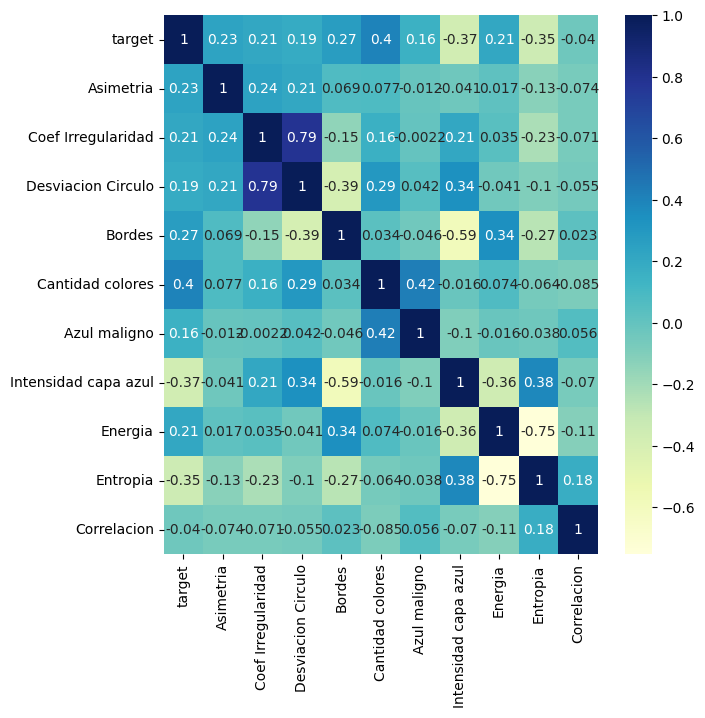

In [ ]:
corr = X[X.columns].corr(numeric_only = True)
plt.figure(figsize=(7,7))
sns.heatmap(corr, cmap="YlGnBu", annot=True);

In [ ]:
X.corrwith(X.target, method='pearson')

target                  1.000000
Asimetria               0.234369
Coef Irregularidad      0.208607
Desviacion Circulo      0.191987
Bordes                  0.269504
Cantidad colores        0.398944
Azul maligno            0.157414
Intensidad capa azul   -0.370225
Energia                 0.211039
Entropia               -0.348378
Correlacion            -0.040000
dtype: float64

Se puede apreciar como la mayoria de las caracterisitcas calculadas poseen una correlacion de entre 0.15 y 0.40 con el outcome, lo cual indica que las metricas calculadas son informativa a la hora de decidir si cierta lesion es maligna o benigna

Se realizo "gráfico de pares" de Seaborn ya que permite visualizar gráficos de cada combinación de varios atributos juntos, para buscar patrones interesantes entre las características.

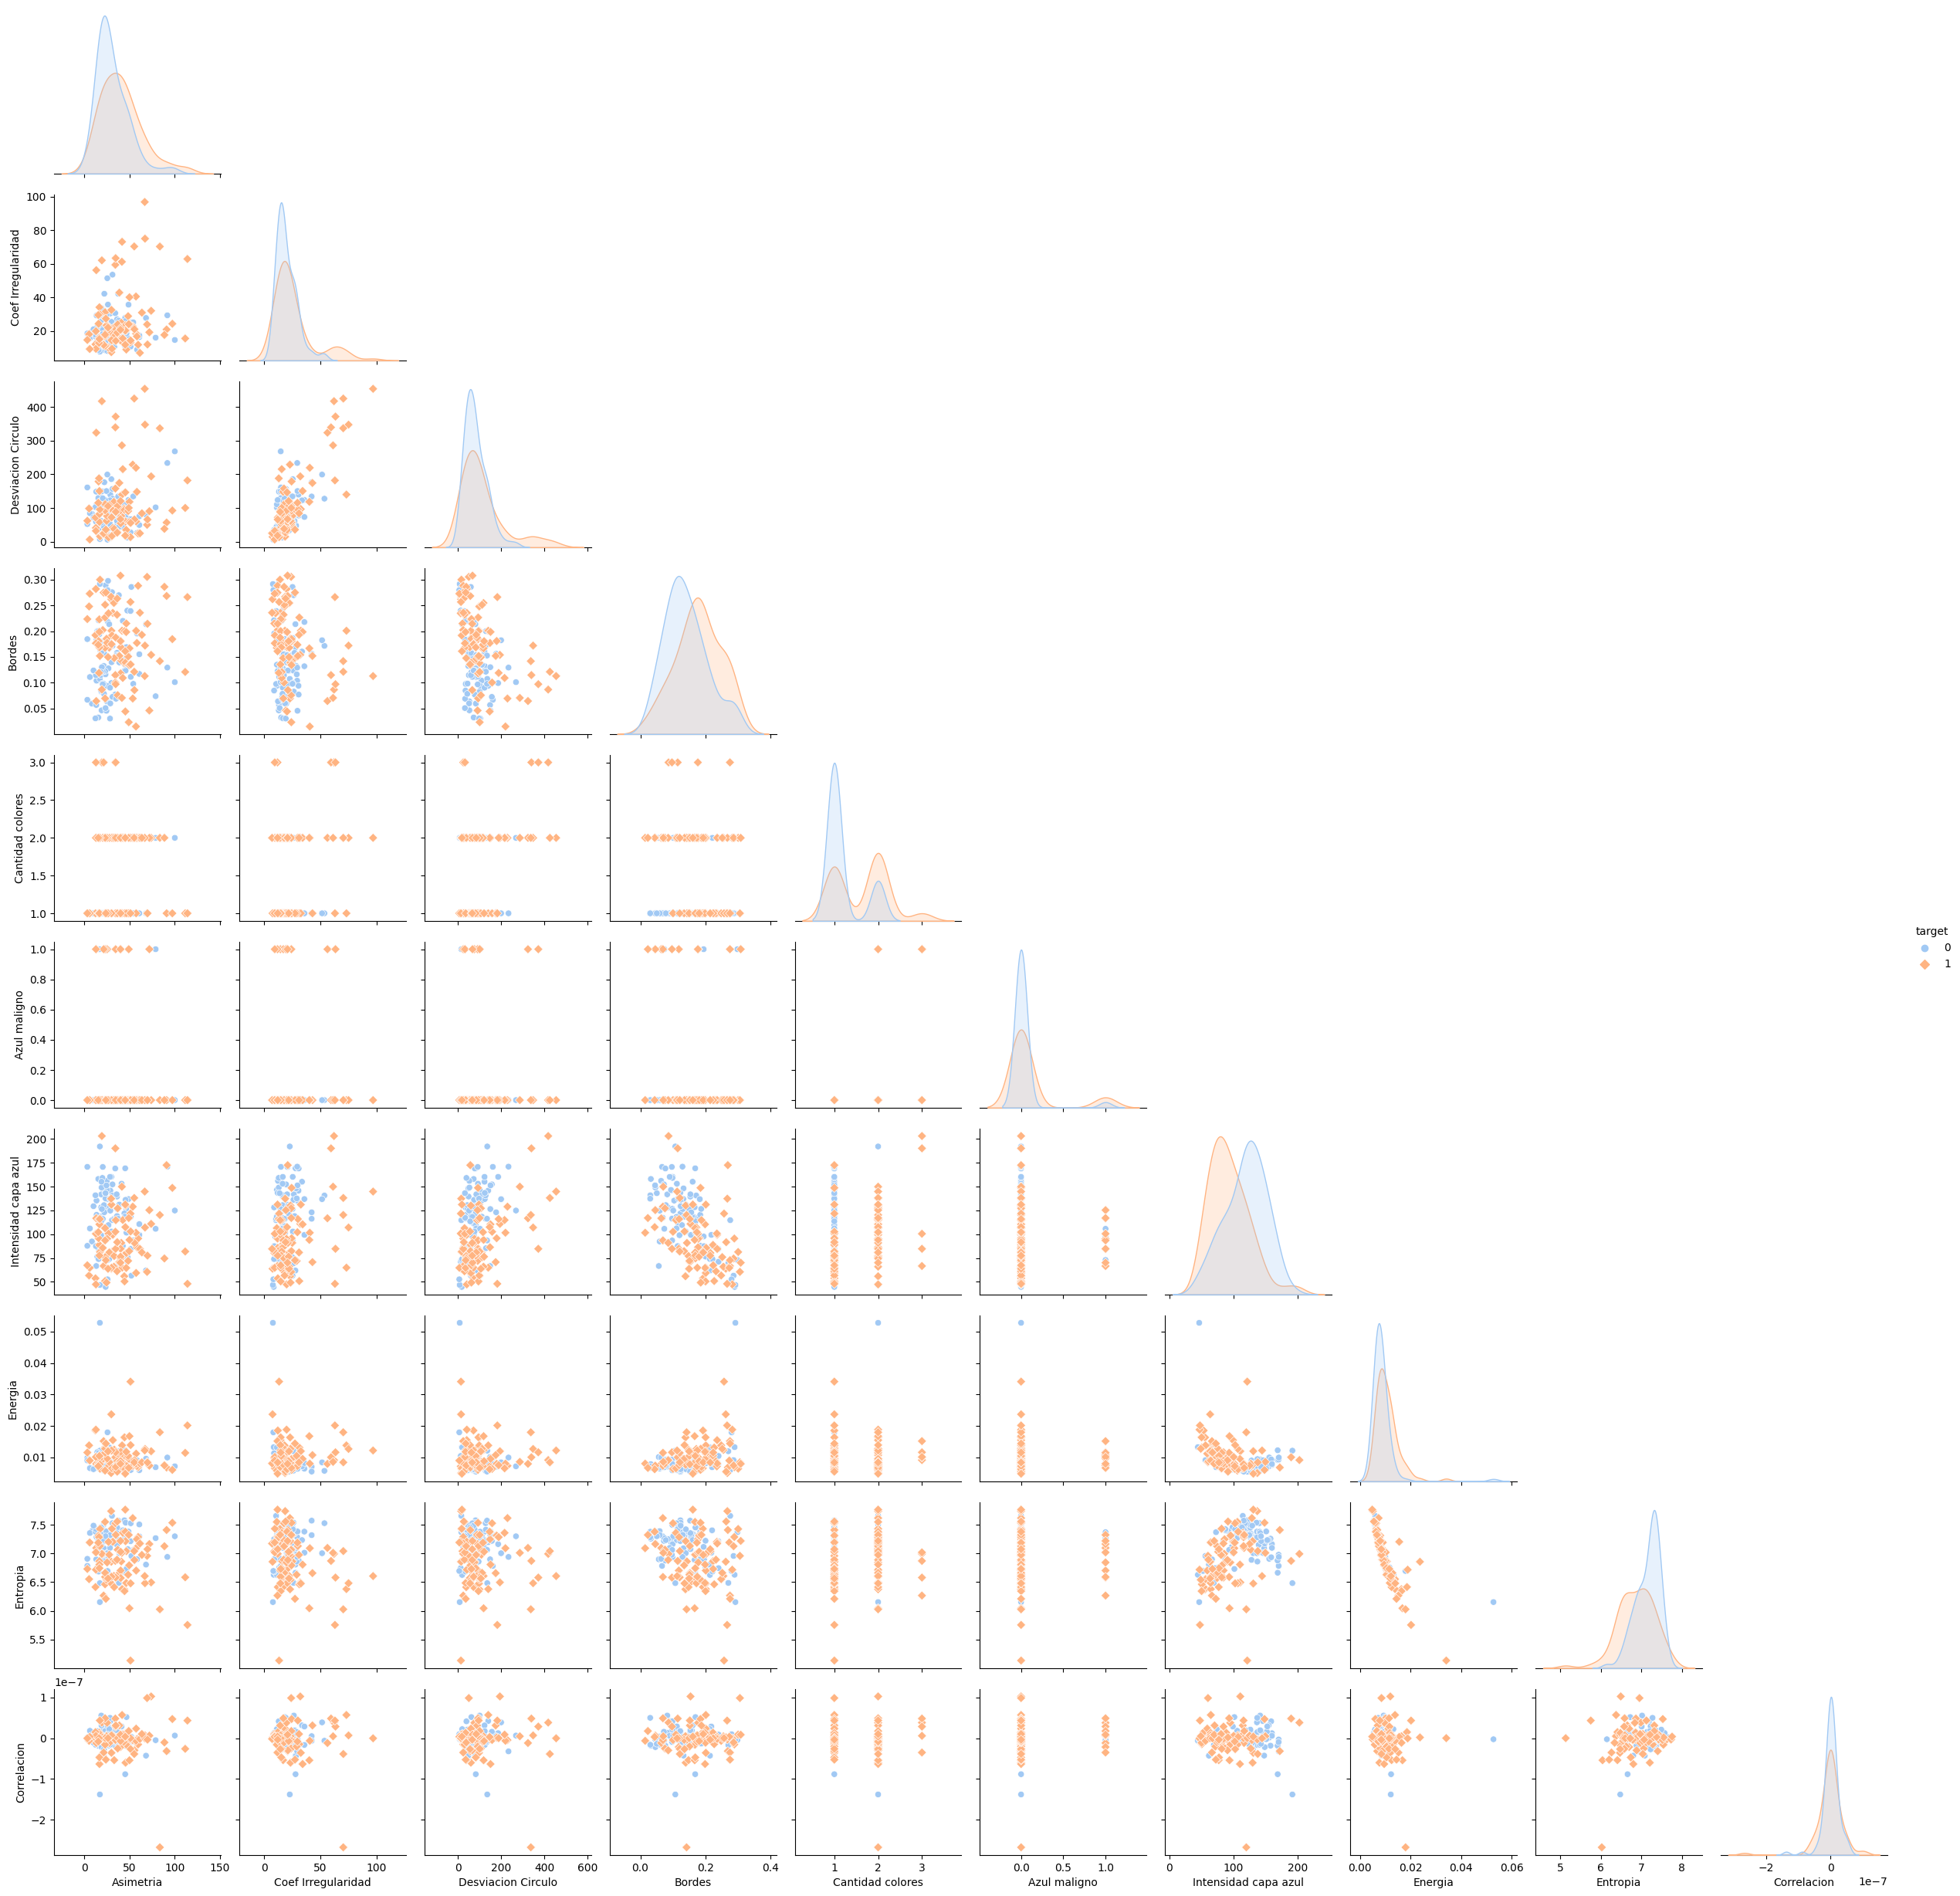

In [ ]:
sns.pairplot(X, hue = 'target', palette = 'pastel', markers = ['o', 'D'], corner = True);

###Modelo

Para comenzar a entrenar el modelo, se separan los 175 datos en un grupo de train (70%) y otro grupo de test (30%). En el grupo train se usará para entrenar el modelo, y el grupo test para evaluar el desempeño, es decir, sobre las características del grupo test, se aplica el modelo y se predice el target, y luego se compara con el target real para ver si predijo correctamente o no el modelo.



In [ ]:
X = db.copy()
y = X.target

#Eliminamos la columna que define el diagnóstico del caso y las varibles que no nos interesan
X = db.drop(['target', 'age_approx','anatom_site_general_challenge',	'diagnosis', 'benign_malignant', 'image_name', 'patient_id', 'sex', 'Asimetria 1','Coef Irregularidad 1','Coef Irregularidad 3','Circularidad', 'Momento Diferencia Inversa', 'Energia', 'Entropia', 'Correlacion'],axis=1)

Buscamos el mejor *random state*

In [ ]:
random_states = np.arange(start=0, stop=101)

# Initialize a list where we'll store the score of each random_state
scores = []

# Initialize search
for state in random_states:
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=state, test_size=0.3)
    rf = RandomForestClassifier(random_state=state)
    rf.fit(xtrain, ytrain)
    scores.append(rf.score(xtest, ytest))

In [ ]:
max=np.max(scores)
indice = scores.index(max)
print("Random state: " ,indice)

Random state:  65


Separamos los datos en *train* y *test*

In [ ]:
random_state = 65 # para asegurar reproducibilidad de los resultados
ts = 0.3 # test size, el estandar es 30% del

xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state, test_size=ts)
print('Training on '+str(ytrain.size)+' examples')

Training on 122 examples


Primero se entrenaron distintos modelos sin ajuste preliminar de hiperparametros, para evaluar el accuracy general de cada modelo

In [ ]:
#Creación de Modelos
sv = SVC(random_state=65)
dt = DecisionTreeClassifier(random_state=65)
kn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=65)


models = [sv, dt, kn, rf]

for model in models:
  model.fit(xtrain, ytrain)
  y_pred = model.predict(xtest)
  print(model)
  print("\tAcurracy:", accuracy_score(ytest, y_pred))
  print(classification_report(ytest, y_pred))
  print()

SVC(random_state=65)
	Acurracy: 0.7358490566037735
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.74      0.74      0.74        27

    accuracy                           0.74        53
   macro avg       0.74      0.74      0.74        53
weighted avg       0.74      0.74      0.74        53


DecisionTreeClassifier(random_state=65)
	Acurracy: 0.6792452830188679
              precision    recall  f1-score   support

           0       0.66      0.73      0.69        26
           1       0.71      0.63      0.67        27

    accuracy                           0.68        53
   macro avg       0.68      0.68      0.68        53
weighted avg       0.68      0.68      0.68        53


KNeighborsClassifier()
	Acurracy: 0.7358490566037735
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.74      0.74      0.74        27

    ac

Luego con los mismos modelos probados anteriormente, se realizo un ajuste de sus hiperparametros con el objetivo de mejorar mas aun el accuracy

In [ ]:
model_lbls = ['dt', 'svc', 'knn', 'rf']

# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,20)]}]
tuned_param_svc = [{'kernel': ['rbf'],
                    'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                    'C': [1, 10, 100, 1000, 10000],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100, 1000],
                    },
                   ]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
tuned_param_rf = [{'max_depth': [*range(5,15)],
                   'n_estimators':[*range(10,100,10)]}]

models = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(random_state=65),
           'param': tuned_param_dt,
          },
    'svc':{'name': 'Support Vector',
           'estimator': SVC(),
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
       },
    'rf': {'name': 'Random forest',
           'estimator': RandomForestClassifier(random_state=65),
           'param': tuned_param_rf
          }
}
scores = ['precision', 'recall']

In [ ]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = ytest, model.predict(xtest)
    print("Acurracy score: ",accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
best_scores = {}

for key in model_lbls:
  #models[key]['estimator'].fit(xtrain,ytrain)
  #predictions = models[key]['estimator'].predict(xtest)
  grid = GridSearchCV(estimator=models[key]['estimator'], param_grid=models[key]['param'], refit = scores)
  grid.fit(xtrain,ytrain)
  #grid_predictions = grid.predict(xtest)
  print('Trying model '+ models[key]['name'])
  print_results(grid)
  best_scores.update( {key : grid.best_score_} )

print('--------------')
print('Dictionary with best scores:')
print(best_scores)

Trying model Decision Tree
Best parameters set found on train set:

{'max_depth': 1}

Grid scores on train set:

0.688 (+/-0.087) for {'max_depth': 1}
0.656 (+/-0.142) for {'max_depth': 2}
0.664 (+/-0.113) for {'max_depth': 3}
0.599 (+/-0.128) for {'max_depth': 4}
0.581 (+/-0.167) for {'max_depth': 5}
0.598 (+/-0.167) for {'max_depth': 6}
0.598 (+/-0.169) for {'max_depth': 7}
0.582 (+/-0.133) for {'max_depth': 8}
0.590 (+/-0.137) for {'max_depth': 9}
0.573 (+/-0.136) for {'max_depth': 10}
0.573 (+/-0.136) for {'max_depth': 11}
0.573 (+/-0.136) for {'max_depth': 12}
0.573 (+/-0.136) for {'max_depth': 13}
0.573 (+/-0.136) for {'max_depth': 14}
0.573 (+/-0.136) for {'max_depth': 15}
0.573 (+/-0.136) for {'max_depth': 16}
0.573 (+/-0.136) for {'max_depth': 17}
0.573 (+/-0.136) for {'max_depth': 18}
0.573 (+/-0.136) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Acu

Del modelo de mayor accuracy, Random Forest, se procedio a ajustar mas detalladamente los hiperparametros en caso de poder mejorar aun mas su desempeño

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],  # Diferentes números de árboles
    'max_depth': [5, 10, 15, 20, 25, 30, 35],  # Profundidades máximas
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo con Grid Search
grid_search.fit(xtrain, ytrain)  # Asume que tienes X_train e y_train definidos

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_rf = RandomForestClassifier(**best_params,random_state=65)
best_rf.fit(xtrain, ytrain)  # Entrenar con los mejores parámetros
y_pred = best_rf.predict(xtest)  # Predecir en el conjunto de prueba
accuracy = accuracy_score(ytest, y_pred)

print("Precisión en el conjunto de prueba:", accuracy)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Precisión en el conjunto de prueba: 0.8301886792452831


Se obtiene entonces como modelo definitivo el siguiente:

In [ ]:
modelo = RandomForestClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30, random_state=65)
modelo.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=5, n_estimators=30, random_state=65)

In [ ]:
y_true, y_pred = ytest, modelo.predict(xtest)
print(classification_report(y_true, y_pred))
print(accuracy_score(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82        26
           1       0.80      0.89      0.84        27

    accuracy                           0.83        53
   macro avg       0.83      0.83      0.83        53
weighted avg       0.83      0.83      0.83        53

0.8301886792452831


###Metricas de evaluacion

In [ ]:
cm = confusion_matrix(ytest, y_pred)

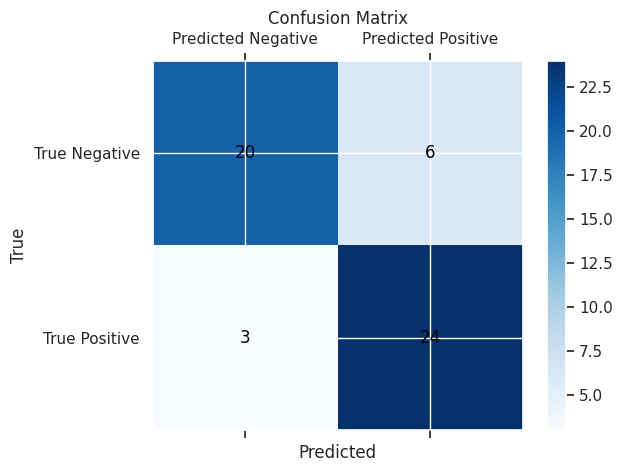

In [ ]:
tn, fp, fn, tp = cm.ravel()

# Visualizar la matriz de confusión
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['True Negative', 'True Positive'])

# Añadir los valores en la matriz de confusión
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(ytest, modelo.predict_proba(xtest)[:, 1])
roc_auc = auc(fpr, tpr)

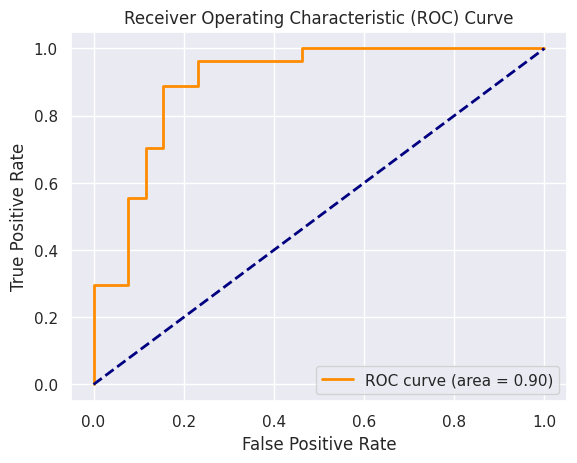

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
sensitivity = recall_score(ytest, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(f"Sensibilidad (Recall): {sensitivity:.2f}")
print(f"Especificidad: {specificity:.2f}")

Sensibilidad (Recall): 0.89
Especificidad: 0.77


#Resultados

Ahora vamos a corroborar el funcionamiento del modelo, se predice el *target* de las dos imagenes de referencia. El modelo requiere como entrada los parametros adquiridas en la seccion "Extraccion de Caracteristicas". En base a estas caracteristicas, el modelo asigna una probabilidad de que esa lesion sea maligna.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

In [ ]:
imagen_benigna=[asimetria2_ben,irr_borde_ben,desv_circulo_ben,borde_canny_ben,cantidad_ben, tiene_color_azul_ben, promedio_ben, energia_roi_azul, entropia_roi_azul,correlacion_roi_azul]
imagen_maligna=[asimetria2_mal,irr_borde_mal,desv_circulo_mal,borde_canny_mal,cantidad_mal, tiene_color_azul_mal, promedio_mal, energia_roi_mal_azul, entropia_roi_mal_azul,correlacion_roi_mal_azul]

In [ ]:
prediction_ben = modelo.predict_proba([imagen_benigna])[:, 1]

print("Probabilidad que asigna el modelo a la imagen benigna: ",np.round(prediction_ben[0]*100,2),'%')

Probabilidad que asigna el modelo a la imagen benigna:  16.27 %


In [ ]:
prediction_mal = modelo.predict_proba([imagen_maligna])[:, 1]

print("Probabilidad que asigna el modelo a la imagen maligna: ",np.round(prediction_mal[0]*100,2),'%')

Probabilidad que asigna el modelo a la imagen maligna:  78.13 %


Se concluye entonces que el modelo funciona correctamente para estas dos imagenes, y debido a la precision y especificidad obtenidas, es eficaz en la clasificación de lesiones malignas o melanomas de manera automática y precisa

#Conclusión

Se concluye que el algoritmo generado es eficaz en la clasificación de lesiones malignas o melanomas de manera automática y precisa, dado que presenta una precisión de 83,02%, una especificidad de 76,92% y una sensibilidad o recall de 88,88%. A su vez, se encuentra integrado a una interfaz funcional.


Es importante destacar que el target de las base de datos clasifica mediante estudios histopatológicos, es decir, biopsias. Aunque esta metodología proporciona una base objetiva y médicamente respaldada, se considera que hubiese sido mejor trabajar sobre una clasificación inicial basada en la evaluación visual de dermatólogos. Esto es debido a que nuestro algoritmo extrae métricas y características que son basadas en forma, color, textura, las cuales se utilizan para entrenar el modelo. Se sostiene, entonces, que haber usado como entrenamiento un database clasificado según un experto en lugar de una biopsia, hubiese dado mejores resultados en cuanto a la sensibilidad y precisión del modelo.


Por otro lado, la cantidad de imágenes utilizadas para entrenar el modelo podría aumentarse para lograr mejores resultados. En este caso,  el trabajo se encontraba limitado por un tema de RAM al correr el código y que la base de datos eran pocas las imágenes malignas en comparación con las benignas que cumplieran las especificaciones previamente mencionadas (pelos gruesos, bordes negros, artefactos no correspondientes a las lesiones, etc.)


En conclusión, se ha desarrollado un clasificador mediante el procesamiento de imágenes, lo cual ha posibilitado la extracción de las características necesarias para identificar lesiones a través de un modelo de Machine Learning. Este proceso se llevó a cabo aplicando los conocimientos adquiridos durante la materia, tales como el mejoramiento de la imagen, la detección de bordes, la segmentación y el análisis de texturas. Estos enfoques no solo se emplearon para cumplir con la regla ABCDE, sino también para innovar en la adquisición de características particulares de lesiones malignas y aumentar la eficiencia del clasificador.
